In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, recall_score
import seaborn as sns
from sklearn.model_selection import StratifiedKFold





In [2]:
# Load dataset
data = pd.read_csv('data.csv')
# Display the first few rows of the dataset
print(data.columns)

Index(['Unnamed: 0', 'location', 'country', 'gender', 'age', 'vis_wuhan',
       'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4',
       'symptom5', 'symptom6', 'diff_sym_hos', 'result'],
      dtype='object')


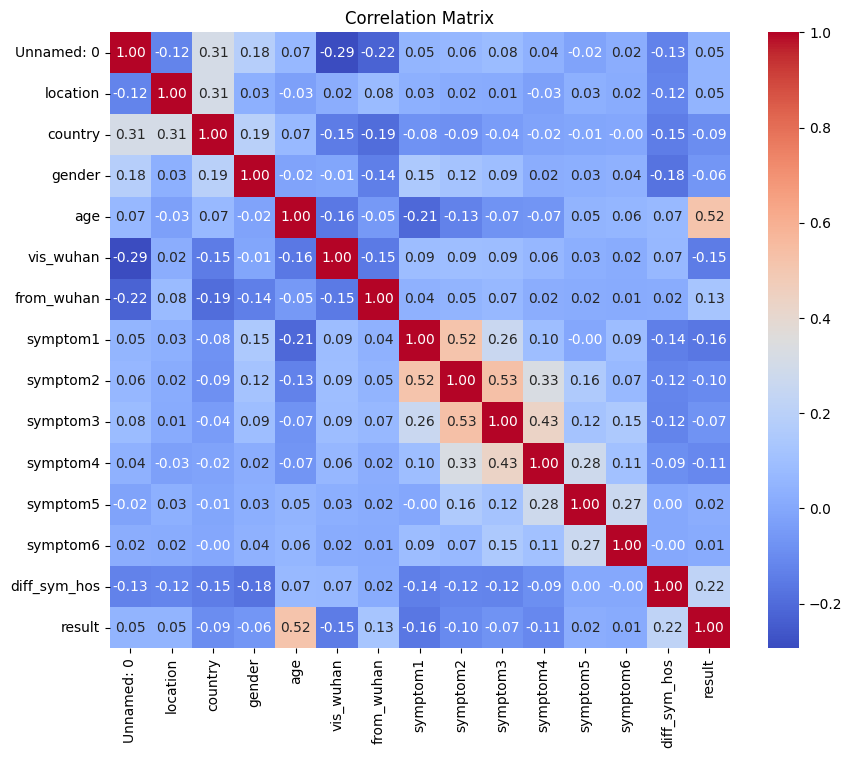

Correlation with target (result):
result          1.000000
age             0.515127
diff_sym_hos    0.219116
from_wuhan      0.128314
Unnamed: 0      0.046838
location        0.046240
symptom5        0.020676
symptom6        0.012882
gender         -0.061441
symptom3       -0.074982
country        -0.094443
symptom2       -0.103270
symptom4       -0.108723
vis_wuhan      -0.151122
symptom1       -0.163039
Name: result, dtype: float64


In [23]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Get the correlation of each feature with the target ('Result')
target_correlation = correlation_matrix['result'].sort_values(ascending=False)

# Print the correlation of features with the target
print("Correlation with target (result):")
print(target_correlation)


In [17]:
# Feature-target split, drop useless features (have low values of correlation)
X = data.drop(['result', 'Unnamed: 0','location','symptom5','symptom6'], axis=1) 
y = data['result']

# Split into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Total number of samples
total_samples = len(data)

# Calculate sizes and percentages
train_size = len(X_train) / total_samples * 100
val_size = len(X_val) / total_samples * 100
test_size = len(X_test) / total_samples * 100

# Print the data sizes and percentages
print(f"Training set size: {len(X_train)} samples ({train_size:.2f}%)")
print(f"Validation set size: {len(X_val)} samples ({val_size:.2f}%)")
print(f"Testing set size: {len(X_test)} samples ({test_size:.2f}%)")


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)




Training set size: 604 samples (69.99%)
Validation set size: 129 samples (14.95%)
Testing set size: 130 samples (15.06%)


In [18]:
best_k = 0
best_recall = 0

# Create StratifiedKFold with random_state for consistency
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a custom scorer using recall
recall_scorer = make_scorer(recall_score)

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    # Use the recall scorer for cross-validation
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring=recall_scorer)  # 5-fold cross-validation
    mean_recall = cv_scores.mean()
    #print(f"k={k}, Cross-Validation Recall: {mean_recall}")
    if (mean_recall > best_recall) & (k!=1): #to avoid overfitting
        best_k = k
        best_recall = mean_recall

print(f"Optimal number of neighbors (k) for maximum recall: {best_k}")



Optimal number of neighbors (k) for maximum recall: 3


In [19]:
# 5. Train the KNN classifier with the optimal k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [20]:
# 6. Predict on the test set
y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)[:, 1]  # Probability for the positive class

Confusion Matrix:
[[111   3]
 [  3  13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       114
           1       0.81      0.81      0.81        16

    accuracy                           0.95       130
   macro avg       0.89      0.89      0.89       130
weighted avg       0.95      0.95      0.95       130


ROC-AUC Score: 0.9490


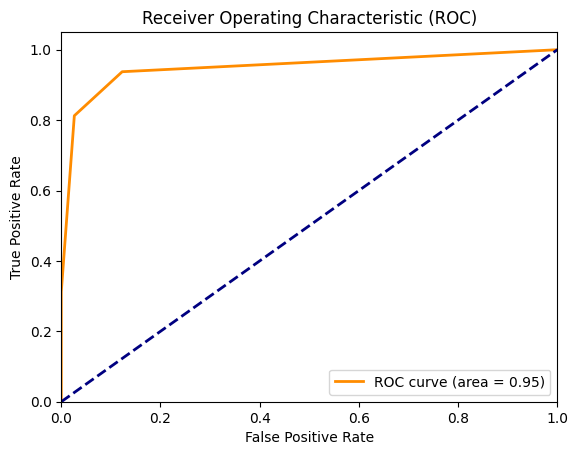

In [21]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()